In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

e:\tool\python36\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [4]:
# 读取数据
data = pd.read_csv('../pm2.5/pollution.csv', index_col=0)
data.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain
date,,,,,,,,
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,SE,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,SE,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,SE,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,SE,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,SE,6.25,2,0


In [5]:
data.shape

(43800, 8)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43800 entries, 2010-01-02 00:00:00 to 2014-12-31 23:00:00
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pollution  43800 non-null  float64
 1   dew        43800 non-null  int64  
 2   temp       43800 non-null  float64
 3   press      43800 non-null  float64
 4   wnd_dir    43800 non-null  object 
 5   wnd_spd    43800 non-null  float64
 6   snow       43800 non-null  int64  
 7   rain       43800 non-null  int64  
dtypes: float64(4), int64(3), object(1)
memory usage: 3.0+ MB


In [7]:
data.select_dtypes('object').columns

Index(['wnd_dir'], dtype='object')

In [8]:
data.wnd_dir.value_counts()

SE    15290
NW    14130
cv     9384
NE     4996
Name: wnd_dir, dtype: int64

In [9]:
# 将风向编码
lbe = LabelEncoder()
data['wnd_dir'] = lbe.fit_transform(data['wnd_dir'])

In [10]:
# # 可视化
# for i in range(8):
#     plt.subplot(8,1,i+1)
#     plt.plot(data.iloc[:,i])
#     plt.title(data.columns[i])

In [11]:
# 将数据转换成可监督
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j + 1, i)) for j in range(n_vars)]
    # 预测序列 (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j + 1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j + 1, i)) for j in range(n_vars)]
    # 拼接到一起
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # 去掉NaN行
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [12]:
sup_data = series_to_supervised(data.values, n_in=1, n_out=1, dropnan=True)

In [13]:
sup_data.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t),var2(t),var3(t),var4(t),var5(t),var6(t),var7(t),var8(t)
1,129.0,-16.0,-4.0,1020.0,2.0,1.79,0.0,0.0,148.0,-15.0,-4.0,1020.0,2.0,2.68,0.0,0.0
2,148.0,-15.0,-4.0,1020.0,2.0,2.68,0.0,0.0,159.0,-11.0,-5.0,1021.0,2.0,3.57,0.0,0.0
3,159.0,-11.0,-5.0,1021.0,2.0,3.57,0.0,0.0,181.0,-7.0,-5.0,1022.0,2.0,5.36,1.0,0.0
4,181.0,-7.0,-5.0,1022.0,2.0,5.36,1.0,0.0,138.0,-7.0,-5.0,1022.0,2.0,6.25,2.0,0.0
5,138.0,-7.0,-5.0,1022.0,2.0,6.25,2.0,0.0,109.0,-7.0,-6.0,1022.0,2.0,7.14,3.0,0.0


In [14]:
# 只需要预测下一时刻的第一个特征，即pollution
data = sup_data.iloc[:, :9]
data.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t)
1,129.0,-16.0,-4.0,1020.0,2.0,1.79,0.0,0.0,148.0
2,148.0,-15.0,-4.0,1020.0,2.0,2.68,0.0,0.0,159.0
3,159.0,-11.0,-5.0,1021.0,2.0,3.57,0.0,0.0,181.0
4,181.0,-7.0,-5.0,1022.0,2.0,5.36,1.0,0.0,138.0
5,138.0,-7.0,-5.0,1022.0,2.0,6.25,2.0,0.0,109.0


In [15]:
# 特征维度很不整齐
data.describe()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var1(t)
count,43799.000000,43799.000000,43799.000000,43799.000000,43799.000000,43799.000000,43799.000000,43799.000000,43799.000000
mean,94.015388,1.829037,12.459394,1016.446905,1.663531,23.889148,0.052764,0.195027,94.012717
std,92.252497,14.429079,12.193300,10.271186,0.938037,50.011647,0.760591,1.416263,92.253178
min,0.000000,-40.000000,-19.000000,991.000000,0.000000,0.450000,0.000000,0.000000,0.000000
25%,24.000000,-10.000000,2.000000,1008.000000,1.000000,1.790000,0.000000,0.000000,24.000000
50%,68.000000,2.000000,14.000000,1016.000000,2.000000,5.370000,0.000000,0.000000,68.000000
75%,132.500000,15.000000,23.000000,1025.000000,2.000000,21.910000,0.000000,0.000000,132.500000
max,994.000000,28.000000,42.000000,1046.000000,3.000000,585.600000,27.000000,36.000000,994.000000


In [16]:
mns = MinMaxScaler()
data_scaled = mns.fit_transform(data)

In [17]:
# 切分数据集
val_split_point = int(data_scaled.shape[0] * 0.7)
test_split_point = int(data_scaled.shape[0] * 0.8)

train_x, train_y = data_scaled[:val_split_point,:-1], data_scaled[:val_split_point,-1]
val_x, val_y = data_scaled[val_split_point:test_split_point,:-1], data_scaled[val_split_point:test_split_point,-1]
test_x, test_y = data_scaled[test_split_point:,:-1], data_scaled[test_split_point:,-1]

In [18]:
train_x.shape, val_x.shape, test_x.shape

((30659, 8), (4380, 8), (8760, 8))

In [20]:
import numpy as np
train_x = np.expand_dims(train_x , 1)
val_x = np.expand_dims(val_x, 1)
test_x = np.expand_dims(test_x, 1)

In [21]:
train_x.shape

(30659, 1, 8)

In [22]:
# 转换数据类型，进dataloader，构建模型
train_x = torch.from_numpy(train_x).type(torch.FloatTensor)
val_x = torch.from_numpy(val_x).type(torch.FloatTensor)
test_x = torch.from_numpy(test_x).type(torch.FloatTensor)

train_y = torch.from_numpy(train_y).type(torch.FloatTensor)#.cuda() 
val_y = torch.from_numpy(val_y).type(torch.FloatTensor)#.cuda() 
test_y = torch.from_numpy(test_y).type(torch.FloatTensor)#.cuda() 

In [24]:
# 封装TensorDataset和DataLoader
train = TensorDataset(train_x, train_y)
val = TensorDataset(val_x, val_y)
test = TensorDataset(test_x, test_y)

BS = 1024 
train_loader = DataLoader(train, batch_size=BS, shuffle=True)
val_loader = DataLoader(val, batch_size=BS, shuffle=True)
test_loader = DataLoader(test, batch_size=BS, shuffle=True)

In [26]:
# 模型设计
class LSTM(nn.Module):   
    def __init__(self):
        super(LSTM, self).__init__()
        self.lstm = nn.Sequential(
                    nn.LSTM(input_size=8, hidden_size=128),)
        self.f1 = nn.Sequential(
                    nn.ReLU(),
                    nn.Linear(128,64),
                    nn.ReLU(),
                    nn.Linear(64,1))
    def forward(self, x):
        x,_ = self.lstm(x)
        x = self.f1(x)
        return x

In [27]:
# 训练超参数配置
Learning_rate = 0.01
Epoch=20
Theshold = 10

device = 'cpu' #torch.device('cuda:0' if torch.cuda.is_available else 'cpu')

In [28]:
# 实例化模型
model = LSTM()
model.to(device)

LSTM(
  (lstm): Sequential(
    (0): LSTM(8, 128)
  )
  (f1): Sequential(
    (0): ReLU()
    (1): Linear(in_features=128, out_features=64, bias=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [29]:
# 配置训练
optimizer = torch.optim.Adam(model.parameters(), lr=Learning_rate)
criterien = nn.SmoothL1Loss()

In [31]:
# 训练
import time
from tqdm import tqdm
count = 0                            # 计数器，记录val_loss不下降的次数
val_min = float('inf')               # 初始化最小val_loss
 
loss_curse = []                      # 记录train loss
val_loss_curse=[]                    # 记录val loss
val_loss_per_epoch = []

for epoch in range(Epoch):
    start_time = time.time()
    for i,(x,y) in tqdm(enumerate(train_loader)):
        x,y =x.to(device), y.to(device)
        model.train()
        y_pred = model(x)
        # print(y_pred.shape, y.shape)
        loss = criterien(y_pred.squeeze(-1).squeeze(-1), y)
        
        loss_curse.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    print('Epoch:', epoch, 'Train_loss:', loss.item(),time.time()-start_time)  # , 'Val_loss:', val_loss.item(), 'Eta:'
    

30it [00:16,  1.82it/s]
0it [00:00, ?it/s]

Epoch: 0 Train_loss: 0.002163090743124485 16.533775568008423


30it [00:09,  3.26it/s]
0it [00:00, ?it/s]

Epoch: 1 Train_loss: 0.0004118003125768155 9.288424730300903


30it [00:09,  3.06it/s]
0it [00:00, ?it/s]

Epoch: 2 Train_loss: 0.0003196239995304495 9.794411182403564


30it [00:09,  3.15it/s]
0it [00:00, ?it/s]

Epoch: 3 Train_loss: 0.000491651298943907 9.51676630973816


30it [00:10,  2.90it/s]
0it [00:00, ?it/s]

Epoch: 4 Train_loss: 0.000429765583248809 10.358519554138184


30it [00:11,  2.60it/s]
0it [00:00, ?it/s]

Epoch: 5 Train_loss: 0.0003063039039261639 11.56193470954895


30it [00:10,  2.98it/s]
0it [00:00, ?it/s]

Epoch: 6 Train_loss: 0.00038325737114064395 10.082957744598389


30it [00:10,  2.91it/s]
0it [00:00, ?it/s]

Epoch: 7 Train_loss: 0.0005376443732529879 10.309757709503174


30it [00:10,  2.89it/s]
0it [00:00, ?it/s]

Epoch: 8 Train_loss: 0.00031500024488195777 10.39578914642334


30it [00:09,  3.00it/s]
0it [00:00, ?it/s]

Epoch: 9 Train_loss: 0.0004724357568193227 10.001182317733765


30it [00:10,  2.93it/s]
0it [00:00, ?it/s]

Epoch: 10 Train_loss: 0.0004089159774594009 10.244587421417236


30it [00:09,  3.02it/s]
0it [00:00, ?it/s]

Epoch: 11 Train_loss: 0.0006429991917684674 9.945591449737549


30it [00:09,  3.02it/s]
0it [00:00, ?it/s]

Epoch: 12 Train_loss: 0.000438558665337041 9.943984031677246


30it [00:09,  3.05it/s]
0it [00:00, ?it/s]

Epoch: 13 Train_loss: 0.0002953709627036005 9.841340065002441


30it [00:10,  2.95it/s]
0it [00:00, ?it/s]

Epoch: 14 Train_loss: 0.000441635784227401 10.188607931137085


30it [00:09,  3.00it/s]
0it [00:00, ?it/s]

Epoch: 15 Train_loss: 0.00041832888382487 9.993592023849487


30it [00:10,  2.98it/s]
0it [00:00, ?it/s]

Epoch: 16 Train_loss: 0.00045657349983230233 10.066308498382568


30it [00:10,  2.99it/s]
0it [00:00, ?it/s]

Epoch: 17 Train_loss: 0.00042111819493584335 10.035764932632446


30it [00:09,  3.01it/s]
0it [00:00, ?it/s]

Epoch: 18 Train_loss: 0.0006286596762947738 9.98214054107666


30it [00:10,  2.99it/s]

Epoch: 19 Train_loss: 0.0003566353116184473 10.048041343688965


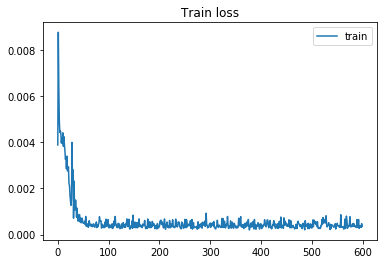

In [32]:
# 绘制训练损失曲线
plt.rcParams['figure.figsize']=(6,4)
pd.DataFrame(loss_curse, columns=['train']).plot()
plt.title('Train loss')
plt.show()

In [40]:
# 保存模型
torch.save(model, 'LSTM.pt')

In [34]:
# 测试集测试
from sklearn.metrics import mean_squared_error, mean_absolute_error
with torch.no_grad():
    model.eval()
    mse, mae = 0, 0
    for i,(x,y) in enumerate(test_loader): 
        y_pred = model(x)
        mse += mean_squared_error(y, y_pred.squeeze(-1).squeeze(-1))
        mae += mean_absolute_error(y, y_pred.squeeze(-1).squeeze(-1))
    
    mse = mse/(i+1)
    mae = mae/(i+1)

In [38]:
print('MSE:', mse, '\nMAE:', mae)

MSE: 0.0006157617899589241 
MAE: 0.013291379126409689
